# 4. Graph

Graphs are perfect to show the interactions between different items. Sometimes called networks, graphs are made up of nodes. Nodes can be connected with each other using edges, which can be both directed and undirected.

In this notebook, we will go through examples of drawing different kinds of networks from scratch.

> Multiplex uses networkx to draw graphs, which means that the package has to be installed. You can learn more about networkx [here](https://networkx.github.io/).

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import matplotlib.pyplot as plt
from networkx import edge_betweenness_centrality
from networkx.algorithms import community
import networkx as nx
import os
import pandas as pd
import sys

path = sys.path[0]
path = os.path.join(path, "..")
if path not in sys.path:
    sys.path.insert(1, path)

The first network is the [Marvel Universe Social Network](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network). Even superheros have friends.

The dataset used is made up of pairs of superheroes that appeared together in the same comic. The dataset is _huge_ so we filter out superhero connections that appear fewer than 50 times together.

In [2]:
df = pd.read_csv('data/the-marvel-universe-social-network/hero-network.csv')
df.columns = ('source', 'target')
df = df.groupby(['source', 'target']).size().reset_index()
df.columns = ('source', 'target', 'frequency')
df = df[df['frequency'] > 50]
df = df[df['source'] != df['target']]
df.sort_values(by='frequency', ascending=False)

,source,target,frequency
142513,PATRIOT/JEFF MACE,MISS AMERICA/MADELIN,1267
124772,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,627
196026,THING/BENJAMIN J. GR,HUMAN TORCH/JOHNNY S,382
85445,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,366
196250,THING/BENJAMIN J. GR,MR. FANTASTIC/REED R,365
...,...,...,...
109528,LOCKHEED,NIGHTCRAWLER/KURT WA,51
18258,BLACK PANTHER/T'CHAL,THOR/DR. DONALD BLAK,51
84219,HULK/DR. ROBERT BRUC,NIGHTHAWK II/KYLE RI,51
213969,"WATSON-PARKER, MARY","OSBORN, HARRY",51


Multiplex draws networks from networkx graphs. Therefore before drawing the Marvel Universe superhero network, we convert the data into a graph. We make the dataset smaller by focusing on the biggest and most popular superheroes in the dataset.

In [3]:
G = nx.convert_matrix.from_pandas_edgelist(df, 'source', 'target')
degree = sorted(G.degree(), key=lambda hero: hero[1], reverse=True)
top = [ hero for hero, neighbours in degree if neighbours > 2 ][:50]
G = G.subgraph(top)
print(f"{ len(G.nodes) } nodes, { len(G.edges) } edges")

50 nodes, 229 edges


As soon as we create the graph, plotting it is as simple as calling the drawable's `draw_graph` method, using `s` to control the node size. The styling for nodes and edges can be passed separately as dictionaries using the `node_style` and `edge_style` parameters.

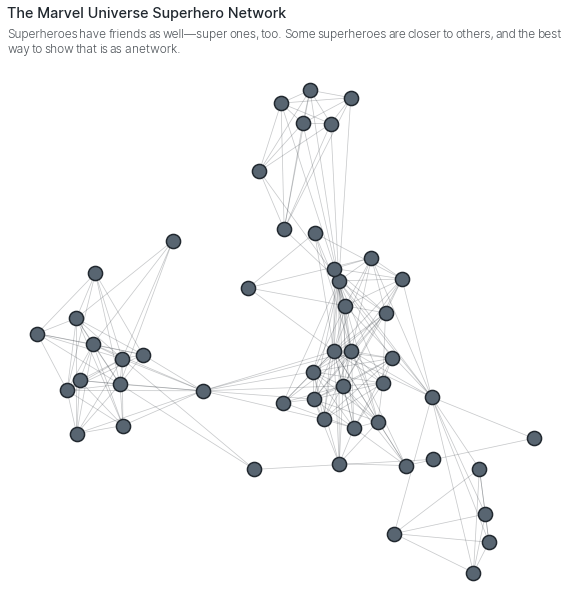

In [4]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': '#586571', 'edgecolor': 'C0', 'linewidth': 1.5 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.25 }
nodes, edges = viz.draw_graph(G, s=200, k=0.6, seed=2,
                              node_style=node_style, edge_style=edge_style)

viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.""")
plt.show()

Some superheroes are closer than others.

In [5]:
def most_central_edge(graph):
    """
    Find the most central edge in the given graph.
    
    :param graph: The graph on which the algorithm operates.
    :type graph: :class:`~networkx.Graph`
    
    :return: The most central edge, made up of the source and edge nodes.
    :rtype: tuple
    """

    centrality = edge_betweenness_centrality(graph)
    return max(centrality, key=centrality.get)
    
communities = community.girvan_newman(G, most_valuable_edge=most_central_edge)
partitions = list(next(communities))
while len(partitions) < len(G.nodes) ** 0.5:
    partitions = list(next(communities))
partitions = [ partition for partition in partitions if len(partition) > 1 ]
partitions = sorted(partitions, key=len, reverse=True)
print(partitions)

[{'INVISIBLE WOMAN/SUE ', "BLACK PANTHER/T'CHAL", 'IRON MAN/TONY STARK ', 'QUICKSILVER/PIETRO M', 'THOR/DR. DONALD BLAK', 'WASP/JANET VAN DYNE ', 'HERCULES [GREEK GOD]', 'SCARLET WITCH/WANDA ', 'CAPTAIN AMERICA', 'VISION ', 'HUMAN TORCH/JOHNNY S', 'HAWK', 'WONDER MAN/SIMON WIL', 'BLACK WIDOW/NATASHA ', 'THING/BENJAMIN J. GR', 'ANT-MAN/DR. HENRY J.', 'MR. FANTASTIC/REED R', 'JARVIS, EDWIN ', 'SHE-HULK/JENNIFER WA'}, {'NIGHTCRAWLER/KURT WA', 'ANGEL/WARREN KENNETH', 'COLOSSUS II/PETER RA', 'WOLVERINE/LOGAN ', 'STORM/ORORO MUNROE S', 'MARVEL GIRL/JEAN GRE', 'HAVOK/ALEX SUMMERS ', 'SHADOWCAT/KATHERINE ', 'CYCLOPS/SCOTT SUMMER', 'PROFESSOR X/CHARLES ', 'BEAST/HENRY &HANK& P', 'ROGUE /', 'ICEMAN/ROBERT BOBBY '}, {'VOLSTAGG', 'LOKI [ASGARDIAN]', 'FANDRAL [ASGARDIAN]', 'BALDER [ASGARDIAN]', 'SIF', 'ODIN [ASGARDIAN]', 'HOGUN [ASGARDIAN]'}, {'SPIDER-MAN/PETER PAR', 'WATSON-PARKER, MARY ', 'PARKER, MAY', 'JAMESON, J. JONAH', 'THOMPSON, EUGENE FLA', 'LEEDS, BETTY BRANT', 'DAREDEVIL/MATT MURDO'}]


The two largest partitions belong to the Avengers and the X-Men. A network too can tell a story. Next, we override the styling of the Avengers and the X-Men to make them pop. Any styling options added to nodes and edges as the `style` attribute overrides any default styles.

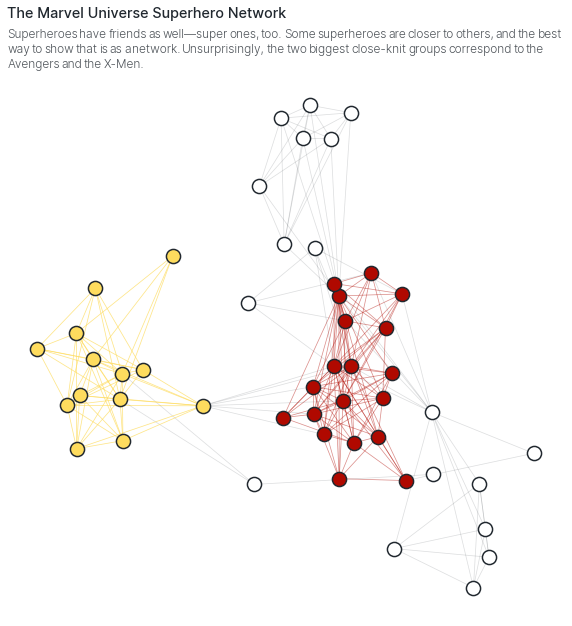

In [6]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

"""
Color the Avengers' nodes and edges red.
"""
for node in partitions[0]:
    G.nodes[node]['style'] = { 'color': '#B00900' }
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[0] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.45, 'color': '#B00900' }

"""
Color the X-Men' nodes and edges yellow.
"""
for node in partitions[1]:
    G.nodes[node]['style'] = { 'color': '#FEDC5E' }
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[1] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.75, 'color': '#FEDC5E' }

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C2', 'edgecolor': 'C0', 'linewidth': 1.5 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
nodes, edges = viz.draw_graph(G, s=200, k=0.6, seed=2,
                              node_style=node_style, edge_style=edge_style)

viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Unsurprisingly, the two biggest close-knit groups correspond to the Avengers and the X-Men.""")
plt.show()

You can learn more about graph visualizations, including functionality that was not covered in this tutorial, on [Multiplex's documentation site](https://nicholasmamo.github.io/multiplex-plot/graph.html).